# <center>Toxic comments classification challenge</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import scipy.special
import matplotlib_venn as venn

import sklearn
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import emoji
import demoji
import contractions
from textblob import TextBlob

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Input, Bidirectional, GlobalMaxPool1D, Dropout

## 1. Data exploration

In [2]:
train_df = pd.read_csv('/Users/Sarah/Desktop/ENSAE/S2/Natural Language Processing/Projet/train.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test_df = pd.read_csv('/Users/Sarah/Desktop/ENSAE/S2/Natural Language Processing/Projet/test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
train_df.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,159571,159571,f14c273035e12174,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comment_text,159571,159571,"""\n\nI was saying the same thing, but forgot t...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toxic,159571,NaN,NaN,NaN,0.0958445,0.294379,0,0,0,0,1
severe_toxic,159571,NaN,NaN,NaN,0.00999555,0.0994771,0,0,0,0,1
obscene,159571,NaN,NaN,NaN,0.0529482,0.223931,0,0,0,0,1
threat,159571,NaN,NaN,NaN,0.00299553,0.0546496,0,0,0,0,1
insult,159571,NaN,NaN,NaN,0.0493636,0.216627,0,0,0,0,1
identity_hate,159571,NaN,NaN,NaN,0.00880486,0.0934205,0,0,0,0,1


In [5]:
train_df.shape

(159571, 8)

In [6]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [7]:
train_df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [8]:
print("Check for missing values in Train dataset")
print(train_df.isnull().sum())
print()
print("Check for missing values in Test dataset")
print(test_df.isnull().sum())

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


In [9]:
x=train_df.iloc[:,2:].sum()

rowsums=train_df.iloc[:,2:].sum(axis=1)
train_df['clean']=(rowsums==0)

train_df['clean'].sum()
print("Total comments = ",len(train_df))
print("Total clean comments = ",train_df['clean'].sum())
print("Total toxic comments = ",len(train_df[train_df['clean']!=1]))
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total toxic comments =  16225
Total tags = 35098


## 2. Data pre-processing

In [10]:
train_df["split"] = "TRAIN"
test_df["split"] = "TEST"

In [11]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,split
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN
...,...,...,...,...,...,...,...,...,...,...
312730,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST
312731,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST
312732,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST
312733,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST


### 2.1) Features extractions

In [12]:
# Comments in capitals
df['capitals'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df["uppercase_comments"] = df['comment_text'].apply(lambda x: 1 if x.isupper() else 0)

In [13]:
# Number of punctuations in comments
df['punctuations'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

In [14]:
# Number of emojis in comments
df['emojis'] = df['comment_text'].apply(lambda comment: sum(comment.count(s) for s in emoji.UNICODE_EMOJI))

In [15]:
# Number of characters in comments
df['length'] = df['comment_text'].apply(len)

In [16]:
# Number of sentences
df['sentences'] = df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

In [17]:
# Number of words
df['words'] = df["comment_text"].apply(lambda x: len(str(x).split()))

### 2.2) Data cleaning

In [18]:
df["clean_comments"] = df["comment_text"].apply(lambda x: x.lower())

In [19]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: contractions.fix(x))

In [20]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F' 
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF' 
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [21]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_URL(x))

In [22]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_html(x))

In [23]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_non_ascii(x))

In [24]:
df["clean_comments"] = df["clean_comments"].apply(lambda x: remove_punct(x))

In [25]:
stop = set(stopwords.words('english'))
df['clean_comments'] = df['clean_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [26]:
filename = "/Users/Sarah/Desktop/ENSAE/S2/Natural Language Processing/Projet/clean_df.hdf5"
key = "CleanData"
df.to_hdf(path_or_buf = filename,  key = key, mode='w')

/Users/Sarah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['id', 'comment_text', 'clean', 'split', 'clean_comments'], dtype='object')]

  pytables.to_hdf(


## 3. Data visualization

In [27]:
filename = "/Users/Sarah/Desktop/ENSAE/S2/Natural Language Processing/Projet/clean_df.hdf5"
key = "CleanData"
df = pd.read_hdf(filename,key)

In [28]:
train_df = df.loc[df.split == "TRAIN"].reset_index(drop=True)
train_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,split,capitals,uppercase_comments,punctuations,emojis,length,sentences,words,clean_comments
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN,17,0,10,0,264,2,43,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN,8,0,12,0,112,1,17,daww matches background colour I seemingly stu...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN,4,0,6,0,233,1,42,hey man I really trying edit war guy constantl...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN,11,0,21,0,622,5,113,make real suggestions improvement wondered sec...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0.0,0.0,0.0,0.0,0.0,0.0,True,TRAIN,2,0,5,0,67,1,13,sir hero chance remember page


In [29]:
test_df = df.loc[df.split == "TEST"].reset_index(drop=True)
test_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,split,capitals,uppercase_comments,punctuations,emojis,length,sentences,words,clean_comments
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST,4,0,12,0,367,1,72,yo bitch ja rule succesful ever hating sad mof...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST,7,0,6,0,50,3,12,rfc title fine I going
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST,4,0,8,0,54,5,12,sources zawe ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST,4,0,6,0,205,1,38,look back source information updated correct f...
4,00017695ad8997eb,I don't anonymously edit articles at all.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TEST,1,0,2,0,41,1,7,anonymously edit articles


In [30]:
types = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

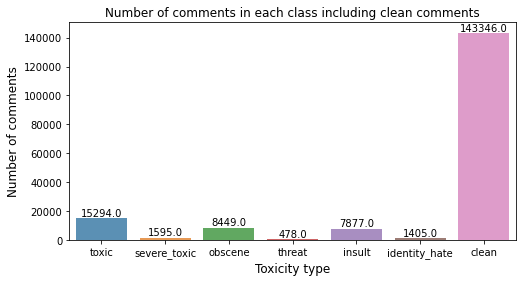

In [31]:
x = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "clean"]].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("Number of comments in each class including clean comments")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Toxicity type', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

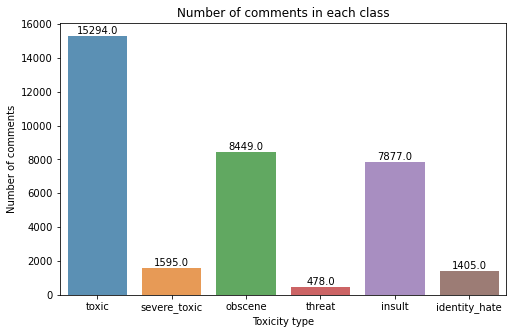

In [32]:
val_counts = train_df[types].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=val_counts.index, y=val_counts.values, alpha=0.8)

plt.title("Number of comments in each class")
plt.xlabel("Toxicity type")
plt.ylabel("Number of comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
    
plt.show()

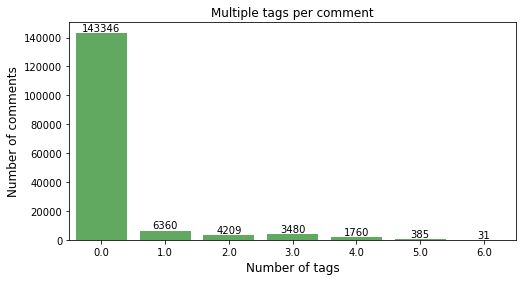

In [33]:
# Number of classes the comment belongs to
train_df["total"] = train_df[types].sum(axis=1)
x=train_df.total.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of tags', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

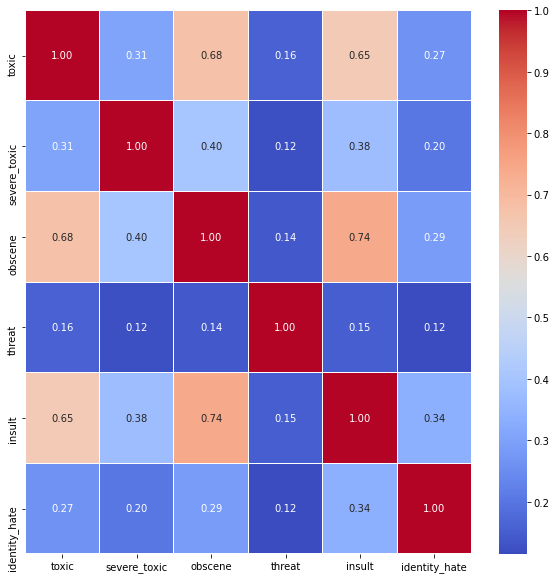

In [34]:
temp_df = train_df[types]
corr=temp_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,
            cmap="coolwarm",
            fmt='.2f',
            linewidths=.05,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

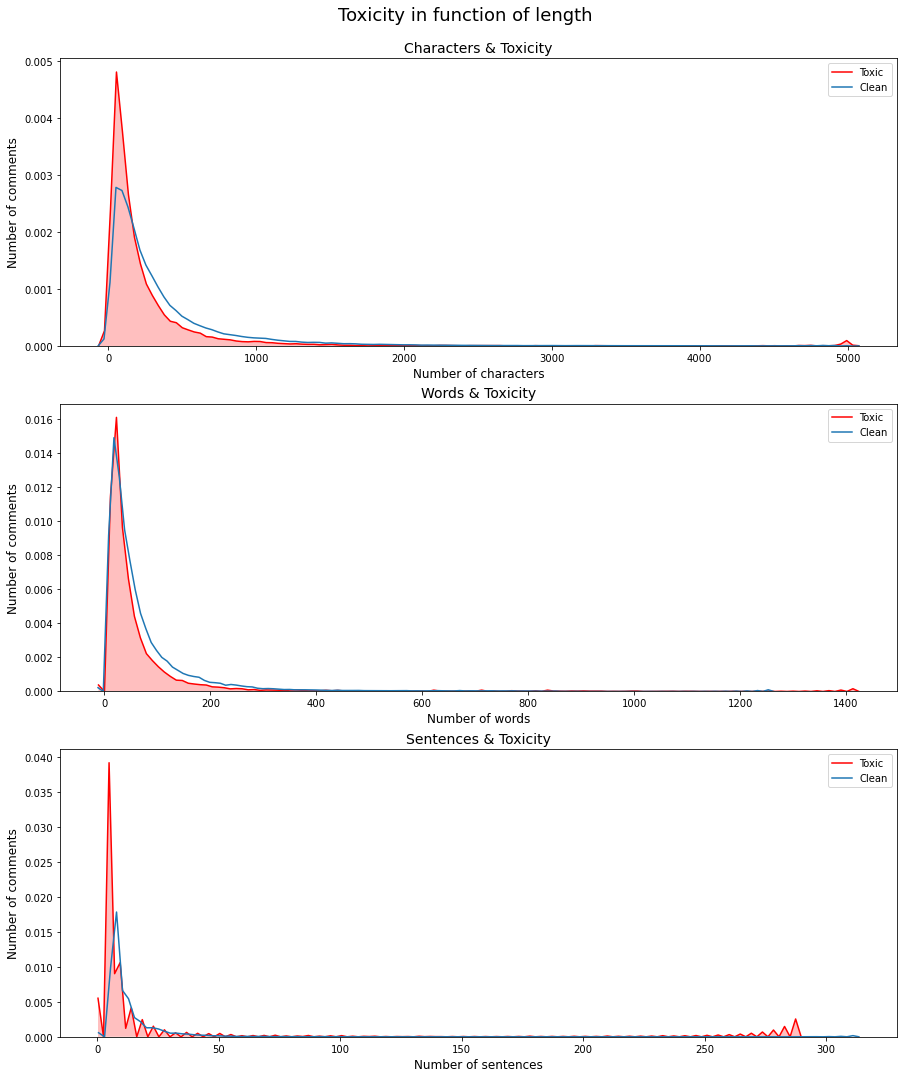

In [35]:
plt.figure(figsize=(15,18))
plt.suptitle("Toxicity in function of length",y=0.92,fontsize=18)
plt.tight_layout()

# Number of characters
plt.subplot(311)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "length"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "length"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of characters', fontsize=12)
plt.title("Characters & Toxicity", fontsize=14)

# Number of words
plt.subplot(312)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "words"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "words"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.title("Words & Toxicity", fontsize=14)

# Number of sentences
plt.subplot(313)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "sentences"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "sentences"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of sentences', fontsize=12)
plt.title("Sentences & Toxicity", fontsize=14)

plt.show()

/Users/Sarah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/Sarah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


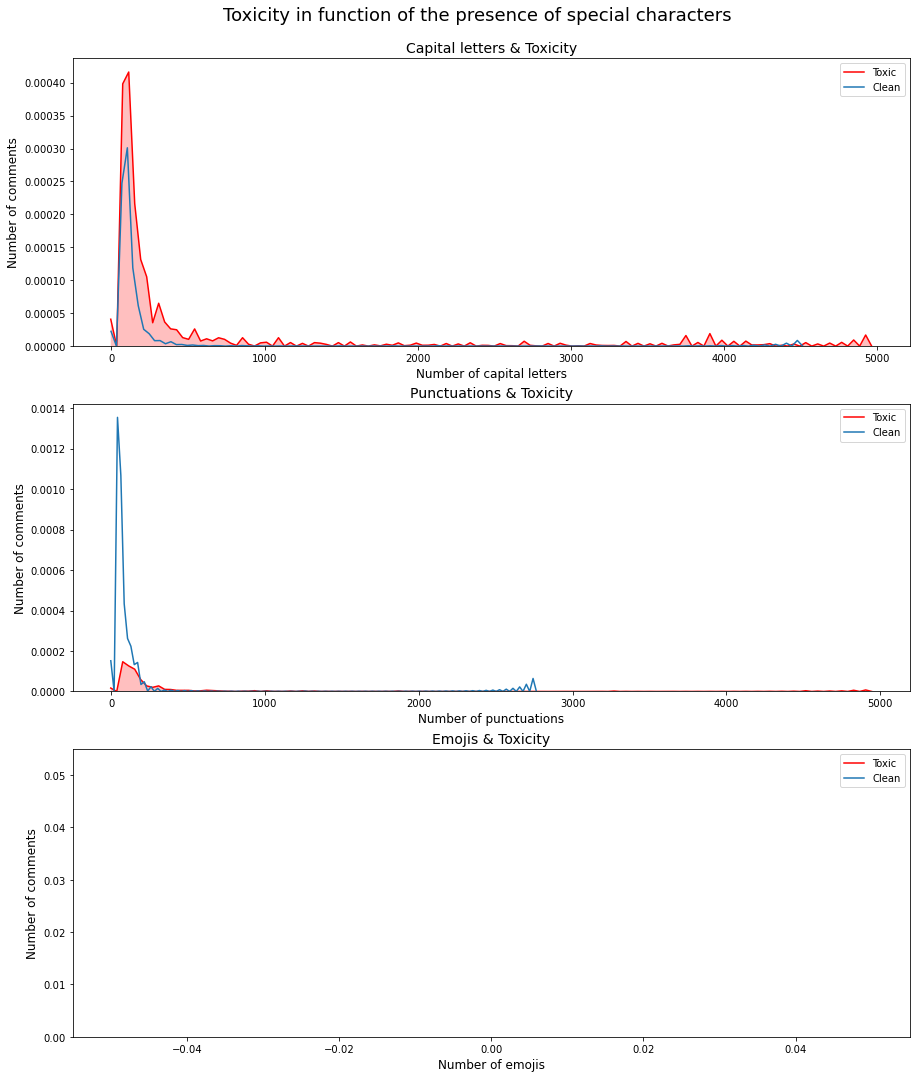

In [36]:
plt.figure(figsize=(15,18))
plt.suptitle("Toxicity in function of the presence of special characters",y=0.92,fontsize=18)
plt.tight_layout()

plt.subplot(311)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "capitals"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "capitals"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of capital letters', fontsize=12)
plt.title("Capital letters & Toxicity", fontsize=14)

plt.subplot(312)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "punctuations"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "punctuations"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of punctuations', fontsize=12)
plt.title("Punctuations & Toxicity", fontsize=14)

plt.subplot(313)
ax=sns.kdeplot(train_df.loc[train_df.clean == 0, "emojis"], label="Toxic", shade=True, color='r')
ax=sns.kdeplot(train_df.loc[train_df.clean == 1, "emojis"], label="Clean")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of emojis', fontsize=12)
plt.title("Emojis & Toxicity", fontsize=14)

plt.show()

In [37]:
compteur = 0
variables = []
values = []

for i in range(len(types)):
    for j in range(i+1, len(types)) :
        compteur += 1
        variables.append(str(types[i] + " & " + types[j]))
        values.append(train_df.loc[(train_df.total == 2) & (train_df[types[i]] == 1) & (train_df[types[j]] == 1)].shape[0])

In [38]:
assert compteur == scipy.special.binom(6, 2)
assert sum(values) == train_df.loc[train_df.total == 2].shape[0]

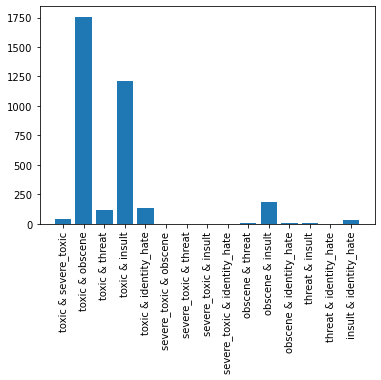

In [39]:
y_pos = range(len(variables))
plt.bar(y_pos, values)
plt.xticks(y_pos, variables, rotation=90)
plt.show()

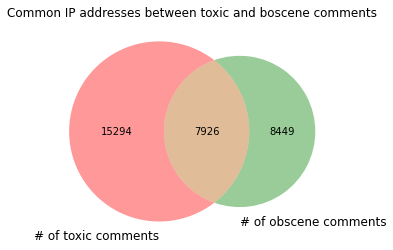

In [40]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
obscene_com = set(train_df.loc[train_df.obscene == 1, "id"].tolist())
common_com = list(toxic_com.intersection(obscene_com))
plt.title("Common IP addresses between toxic and boscene comments")
venn.venn2(subsets=(len(toxic_com),len(obscene_com),len(common_com)),set_labels=("# of toxic comments","# of obscene comments"))
plt.show()

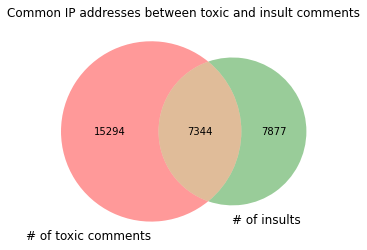

In [41]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
insult_com = set(train_df.loc[train_df.insult == 1, "id"].tolist())
common_com = list(toxic_com.intersection(insult_com))
plt.title("Common IP addresses between toxic and insult comments")
venn.venn2(subsets=(len(toxic_com),len(insult_com),len(common_com)),set_labels=("# of toxic comments","# of insults"))
plt.show()

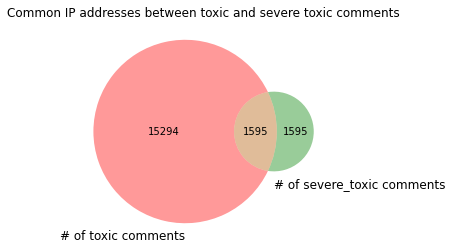

In [42]:
toxic_com = set(train_df.loc[train_df.toxic == 1, "id"].tolist())
severe_toxic_com = set(train_df.loc[train_df.severe_toxic == 1, "id"].tolist())
common_com = list(toxic_com.intersection(severe_toxic_com))
plt.title("Common IP addresses between toxic and severe toxic comments")
venn.venn2(subsets=(len(toxic_com),len(severe_toxic_com),len(common_com)),set_labels=("# of toxic comments","# of severe_toxic comments"))
plt.show()

In [43]:
compteur = 0
variables = []
values = []

for i in range(len(types)):
    for j in range(i+1, len(types)) :
        for k in range(j+1, len(types)) :
            compteur += 1
            variables.append(str(types[i] + " & " + types[j] + " & " + types[k]))
            values.append(train_df.loc[(train_df.total == 3) &
                                       (train_df[types[i]] == 1) &
                                       (train_df[types[j]] == 1) &
                                       (train_df[types[k]] == 1)].shape[0])

In [44]:
assert compteur == scipy.special.binom(6, 3)
assert sum(values) == train_df.loc[train_df.total == 3].shape[0]

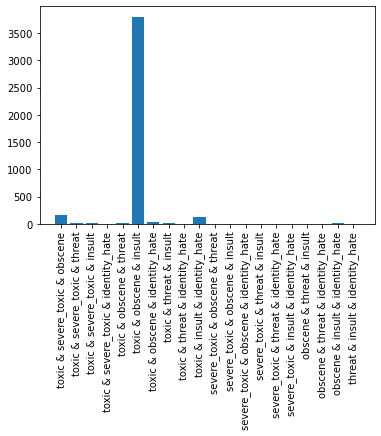

In [45]:
y_pos = range(len(variables))
plt.bar(y_pos, values)
plt.xticks(y_pos, variables, rotation=90)
plt.show()

In [46]:
word_counter = {}

for categ in types:
    d = Counter()
    train_df[train_df[categ] == 1]['clean_comments'].apply(lambda t: d.update(t.split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

In [47]:
%matplotlib inline

(-0.5, 399.5, 199.5, -0.5)

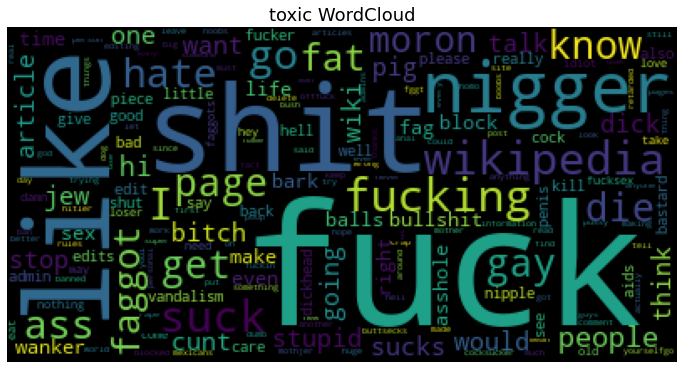

In [48]:
w = 'toxic'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

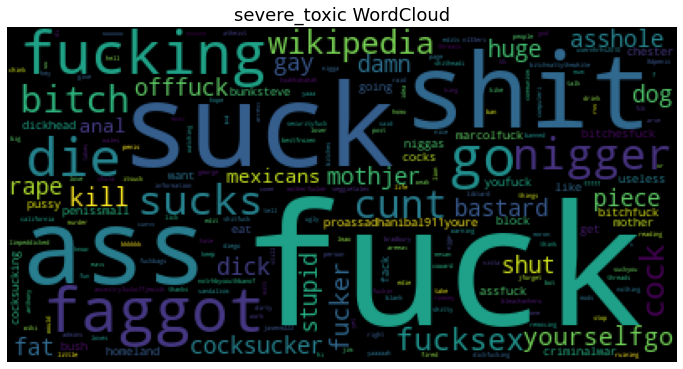

In [49]:
w = 'severe_toxic'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

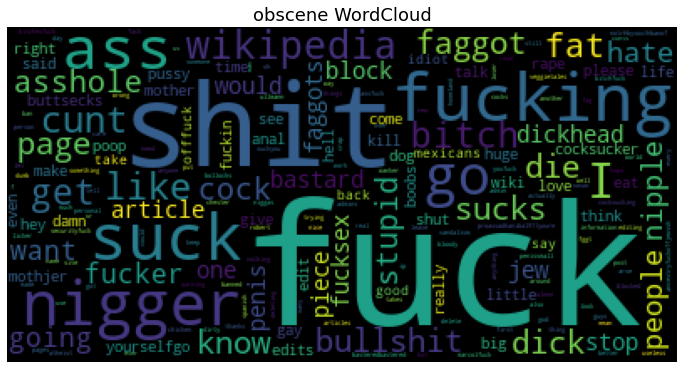

In [50]:
w = 'obscene'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

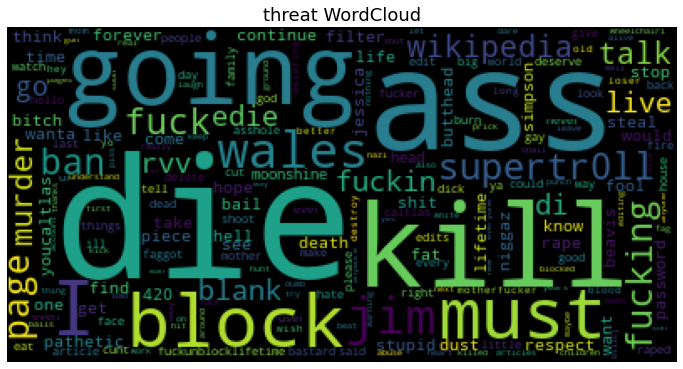

In [51]:
w = 'threat'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

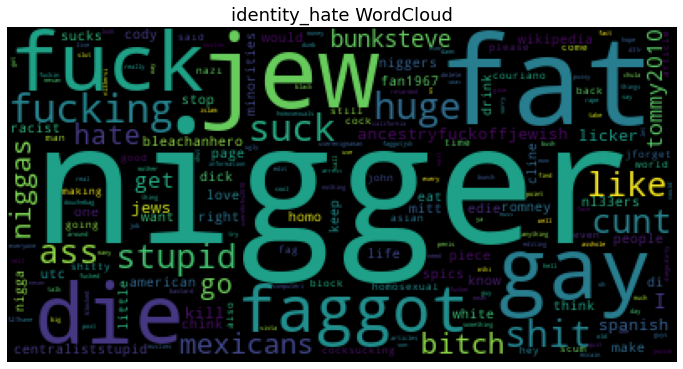

In [52]:
w = 'identity_hate'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

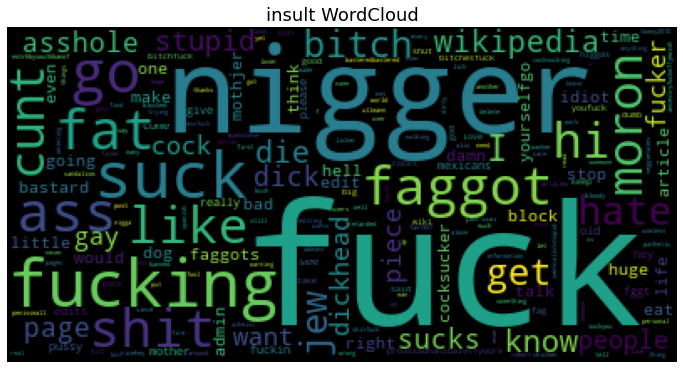

In [53]:
w = 'insult'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

## 4. Modeling

### 4.1) Single task model

### 4.2) Multi tasks model

In [54]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
list_sentences_train = train_df["clean_comments"]
list_sentences_test = test_df["clean_comments"]

In [55]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [56]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [57]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [58]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
## LENT
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
2069/4488 [============>.................] - ETA: 3:49 - loss: 0.0907 - accuracy: 0.9028

KeyboardInterrupt: 

In [ ]:
model.summary()

## ANNEXES

Pour chaque étape, je vais créer une colonne et on verra à quoi ça servira au fur et à mesure !

### Colonne avec les commentaires tokenisés

### Colonne après un Porter Stemmer

In [ ]:
def porter_stemmer(text):
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [ ]:
#train_df['stemmed_text'] = train_df['tokenized_comments'].apply(lambda x: porter_stemmer(x))